In [65]:
import pandas as pd
import numpy as np
import os, gc, math, sys, re
import os,sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from tqdm import *
from datetime import datetime as dt
from datetime import datetime, timedelta
from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool
from sklearn.cluster import KMeans
import time
from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool
import holidays as h

Data fields

for df_1:
- PID - patient ID (unique for each patient)
- EID - exam ID (unique for each patient visit)
- Modality - scanner name (MR1 or MR2)
- Exam - exam name (abbreviated). Corresponds to a particular type of scaning (exam)
- Scheduled - time when the exam was scheduled
- Arrive - time when the patient arrived for this exam
- Begin, Complete - time when exam started/ended
- Scan start - time when scanner started scanning (should be after Begin, but before Complete)
- In PACS - time when the exam was sent to the hospital PACS (Picture Archiving and Communication System) - digital archive of medical images.

for df_2:
- stMRN - unique patient identifier
- stAccession - unique exam identifyer (oe patient may have several exams at the same visit)
- stExamCode - type of exam (exam name)
- stModality - scanning device name (each in its own room)
- dtOrdered - time when the exam was ordered
- dtScheduled - time the exam was scheduled to start at (compare to dtBegin)
- dtCancelled - time they cancelled this exam (if not NULL)
- dtArrive - time when the patient arrived
- dtBegin - time when the exam started
- dtFirstImage - time when they acquired the first patient image. Should come a few minutes after dtBegin
- numImages - number of images acquired
- dtCompleted - time when they finished the exam
- Status - mostly irrelevant (Final for completed, X for cancelled)


Datetime format: MM/DD/YY HH:MM

Scheduled, Arrive, Begin and Complete timestamps are entered manually and may contain errors.

In [66]:
df_1 = pd.read_excel('../MRIDataOneYear.xlsx')
df_2 = pd.read_excel('../ExamData.xlsx')

In [67]:
mapping_cols = {
    'stMRN': 'PID',
    'stAccession': 'EID',
    'stExamCode': 'Exam', 
    'stModality': 'Modality',
    'dtOrdered': None,
    'dtScheduled': 'Scheduled',
    'dtCancelled': None,
    'dtArrive': 'Arrive',
    'dtBegin': 'Begin',
    'dtFirstImage': 'Scan start',
    'numImages': None,
    'dtCompleted': 'Complete',
    'Status': None
    }

In [68]:
for key in mapping_cols.keys():
    if mapping_cols[key] is not None:
        df_2[mapping_cols[key]] = df_2[key]
        del df_2[key]
    else:
        del df_2[key]

common_cols = list(set(df_1.columns).intersection(set(df_2.columns)))

df_1 = df_1[common_cols]
df_2 = df_2[common_cols]
df = pd.concat([df_1, df_2])
df = df.reset_index(drop=True)

#### Explorative data analysis

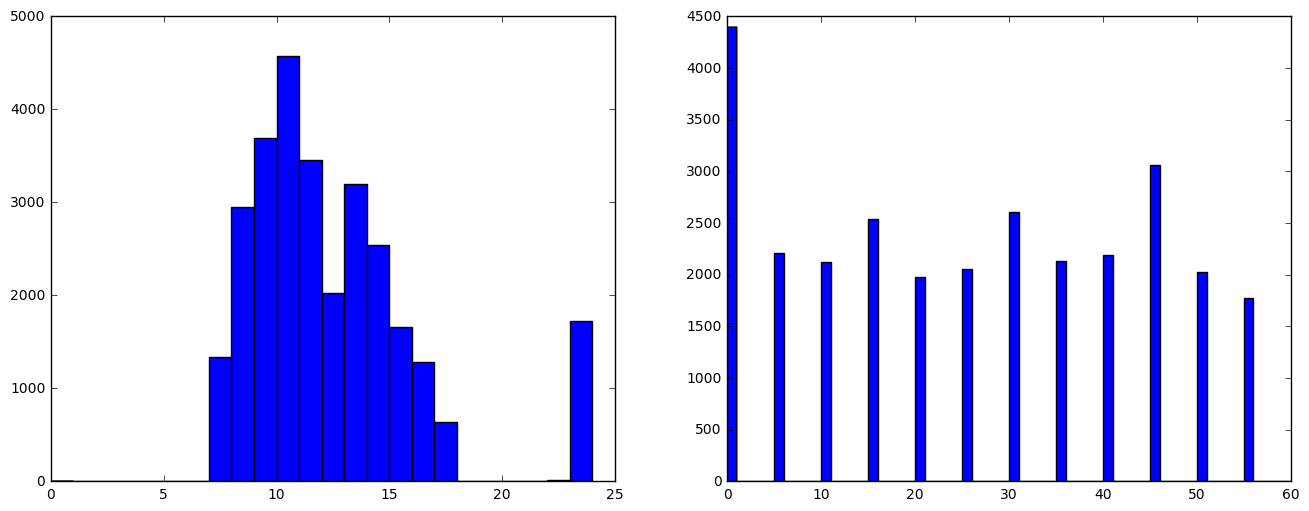

In [69]:
plt.figure(figsize=[16,6])
plt.subplot(121)
a = plt.hist(list(map(lambda x: x.hour, df.Scheduled)),bins = 24,range = [0,24],)
plt.subplot(122)
a = plt.hist(list(map(lambda x: x.minute, df.Scheduled)),bins = 60,range = [0,60])

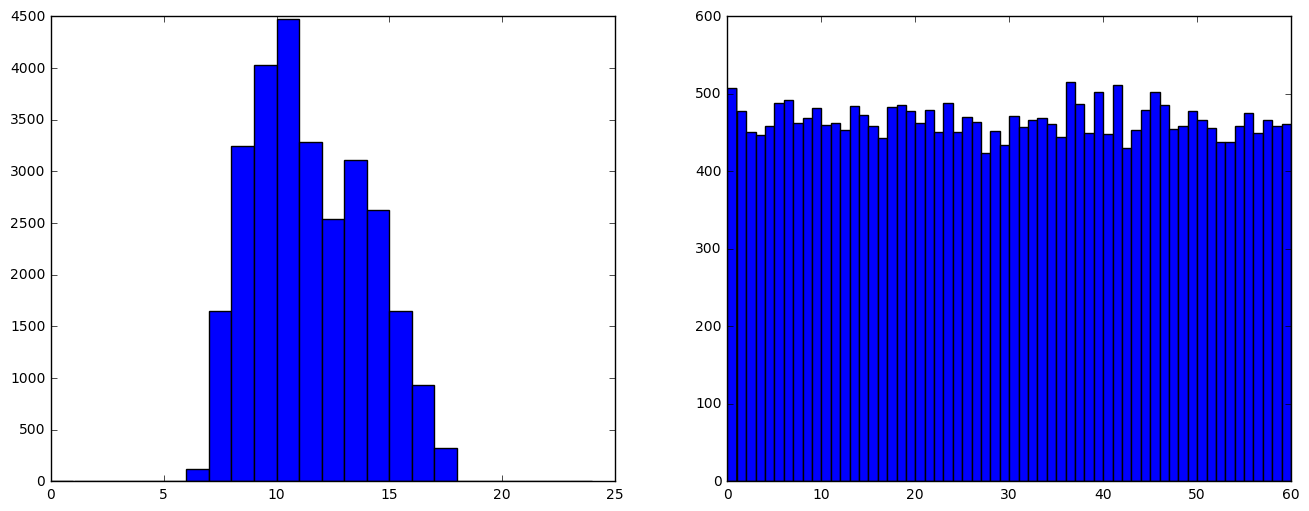

In [70]:
plt.figure(figsize=[16,6])
plt.subplot(121)
a = plt.hist(list(map(lambda x: x.hour, df.Arrive)),bins = 24,range = [0,24],)
plt.subplot(122)
a = plt.hist(list(map(lambda x: x.minute, df.Arrive)),bins = 60,range = [0,60])

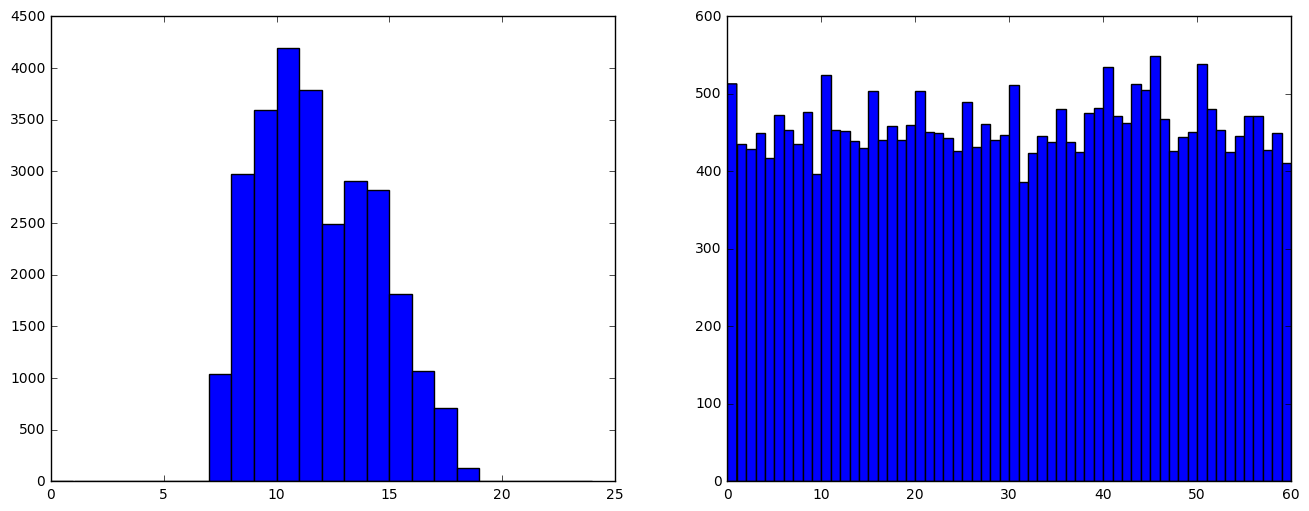

In [71]:
plt.figure(figsize=[16,6])
plt.subplot(121)
a = plt.hist(list(map(lambda x: x.hour, df.Begin)),bins = 24,range = [0,24],)
plt.subplot(122)
a = plt.hist(list(map(lambda x: x.minute, df.Begin)),bins = 60,range = [0,60])

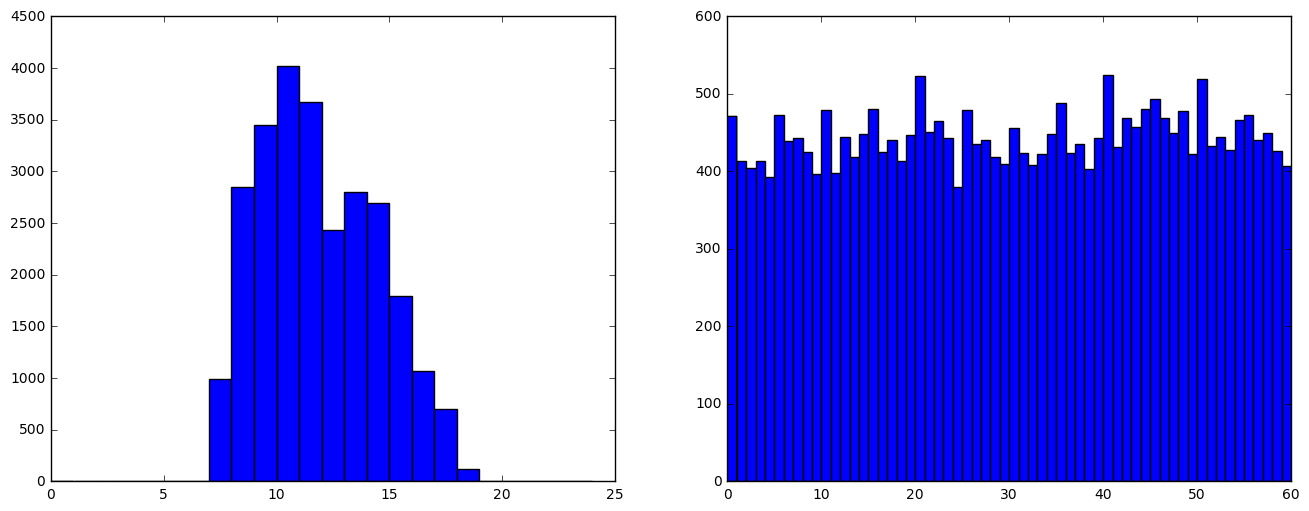

In [72]:
plt.figure(figsize=[16,6])
plt.subplot(121)
a = plt.hist(list(map(lambda x: x.hour, df['Scan start'])),bins = 24,range = [0,24],)
plt.subplot(122)
a = plt.hist(list(map(lambda x: x.minute, df['Scan start'])),bins = 60,range = [0,60])

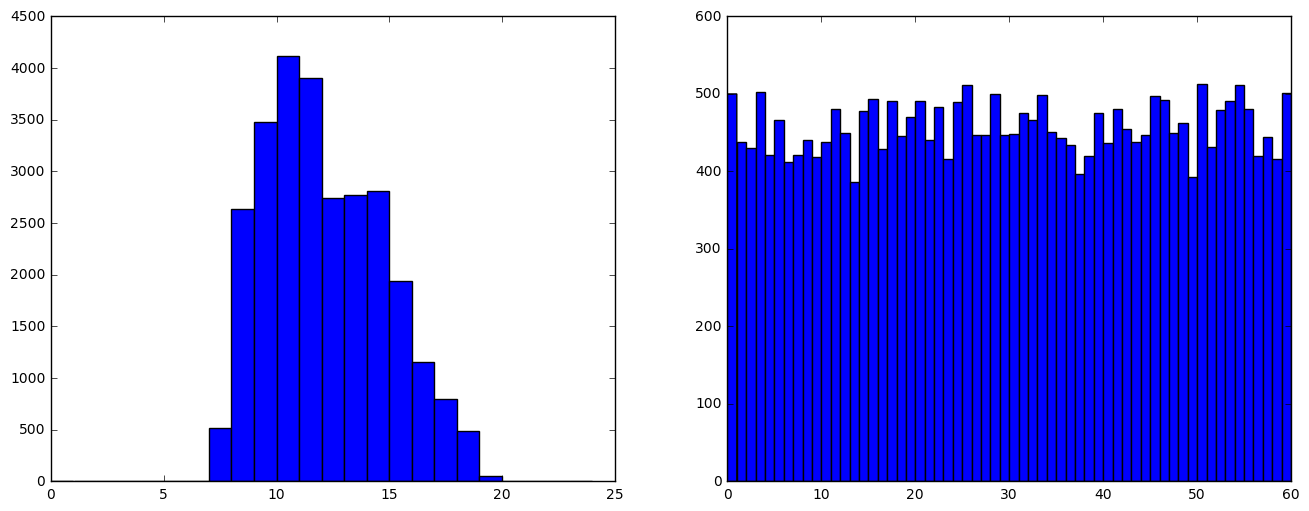

In [73]:
plt.figure(figsize=[16,6])
plt.subplot(121)
a = plt.hist(list(map(lambda x: x.hour, df.Complete)),bins = 24,range = [0,24],)
plt.subplot(122)
a = plt.hist(list(map(lambda x: x.minute, df.Complete)),bins = 60,range = [0,60])

In [74]:
print sum(df['Begin'] > df['Scan start'])

print sum(df['Scan start'] > df['Complete'])

6521
50


#### Data cleaning

In [75]:
df.head()

,Scheduled,Begin,Complete,Scan start,PID,EID,Arrive,Modality,Exam
0,2014-04-07 07:45:00,2014-04-07 07:15:00,2014-04-07 08:27:00,2014-04-07 07:15:00,3406937,24849519,2014-04-07 06:48:00,MR2,MRISPECT
1,2014-04-07 07:45:00,2014-04-07 07:48:00,2014-04-07 08:39:00,2014-04-07 07:48:00,4171966,24144614,2014-04-07 07:04:00,MR1,MRILIVWWO
2,2014-04-07 08:10:00,2014-04-07 08:33:00,2014-04-07 09:17:00,2014-04-07 08:33:00,6169209,24855775,2014-04-07 07:46:00,MR2,MRISHDW
3,2014-04-07 08:30:00,2014-04-07 08:54:00,2014-04-07 09:44:00,2014-04-07 08:54:00,6141059,24869341,2014-04-07 08:19:00,MR1,MRILSNWWO
4,2014-04-07 09:15:00,2014-04-07 09:27:00,2014-04-07 10:21:00,2014-04-07 09:27:00,4425183,24837262,2014-04-07 08:28:00,MR2,MRITSBWWO


##### Если у пациента не заполнено поле Scan start, но есть Begin и Complete, считаем Scan start = Begin

In [76]:
def fill_scan_start(scan_start, begin, complete):
    if not pd.isnull(begin) and not pd.isnull(complete) and pd.isnull(scan_start):
        return begin
    else:
        return scan_start

In [77]:
df['Scan start'] = map(lambda x: fill_scan_start(x[0],x[1],x[2]), zip(df['Scan start'], df.Begin, df.Complete))

##### У части пациентов нет времени завершения исследования, вероятно что-то пошло не так. Предлагаю удалить их из выборки

In [78]:
print 'Было {}'.format(df.shape[0])
df = df[map(lambda begin, complete: pd.isnull(complete) == pd.isnull(begin), df.Begin, df.Complete)]
print 'Стало {}'.format(df.shape[0])

Было 29120
Стало 29004


##### Есть часть пациентов, у которых не указано Arrive время. Для них можно заполнить его минимумом из начала исследования и временем записи

In [81]:
def fill_arrive(arrive, begin, schedule):
    if pd.isnull(arrive) and not pd.isnull(begin) and not pd.isnull(schedule):
        return min(begin, schedule)
    else:
        return arrive

In [82]:
df['Arrive'] = map(lambda x: fill_arrive(x[0],x[1],x[2]), zip(df.Arrive, df.Begin, df.Scheduled))

##### Как мы видим, в данных присутствует достаточно много пациентов, у которых была запись на временной промежуток 23:00 - 23:59

In [83]:
print(df.shape[0])
print(df[map(lambda x: x.hour in [23,0], df.Scheduled)].shape[0])

29004
1718


#### Save file to pickle for next stage

In [84]:
df.to_pickle('../df.pkl')